# Working With Surfaces
## 1. Building Elemental Surfaces

<b>In this lesson and in the corresponding exercises we will learn how to generate specific surfaces of elemental materials, as well as all possible surfaces up to a certain Miller index.</b>
<br><br>

**Copper: (1, 1, 1) surface**

For our first example we will generate a copper (1, 1, 1) surface. Let's start by importing a Cu structure from a .cif file.

In [1]:
from pymatgen.core.structure import Structure

In [2]:
Cu = Structure.from_file("Cu.cif")

<br>We can now start thinking about how to represent surfaces: in <i>pymatgen</i>, this is done through slabs. A slab is a cell containing a few layers of atoms and vacuum, where the termination corresponds to the surface we are interested in. Here is an example of a Cu slab corresponding to a (1, 1, 1) surface:

![Cu slab](Cu_slab.png)

<br><br>If we visualize multiple slabs instead of just one, we can see how the surface-like structure arises. Here is the same slab from above, copied 15 times in the <i>x</i> and <i>y</i> directions, and twice in the <i>z</i> direction:

![Cu slabs](Cu_slabs.png)

<br>Let's now try to generate surfaces using the <i>SlabGenerator</i> class.

In [3]:
from pymatgen.core.surface import SlabGenerator

<br>Let's initialize it for the Cu structure we just created, with a Miller index of (1, 1, 1), a minimum slab height of 10 Å, and minimum 10 Å of vacuum.

In [4]:
slabgen = SlabGenerator(Cu, (1,1,1), 10, 10)

<br><br>We can now use the <i>get_slabs()</i> method of the <i>SlabGenerator</i> class to create a list of <i>Slab</i> objects. The slabs returned by <i>get_slabs()</i> in this case correspond to all the unique terminations along the normal to the Miller plane we are interested in. For example, for the Cu (1, 1, 1) case, the algorithm will find all the unique terminations that are parallel to the (1, 1, 1) plane i.e. perpendicular to the normal. The different resulting slabs are characterized by different c shifts:
![Cu surface finder](Cu_normal_to_surf.png)

In [5]:
slabs = slabgen.get_slabs()

<br>For a fcc structure such as the Cu structure we are working with, there should only be only one unique (1, 1, 1) surface. We can check if that is the case:

In [6]:
print(len(slabs))

1


<br>We can print the Miller index of this surface, as well as the c shift value:

In [7]:
Cu_111 = slabs[0]

print(Cu_111.miller_index, Cu_111.shift)

(1, 1, 1) 0.5


<br>Let's now visualize the surface we just generated. For this, we can use the <i>plot_slab</i> function and we will also need to import <i>pyplot</i>, a python plotting framework.

In [8]:
from pymatgen.analysis.adsorption import plot_slab
from matplotlib import pyplot as plt

%matplotlib inline

<br>We can now plot our surface:

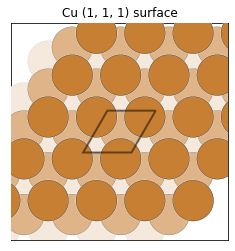

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot_slab(Cu_111, ax, adsorption_sites=False)
ax.set_title("Cu (1, 1, 1) surface")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

<br><br>

## 2. Building Compound Surfaces 

<b>In this part of the tutorial we will extend what we learned about generating elemental surfaces to compound materials by accounting for the additional complexity of such systems.</b>
<br><br>

Let's try something a little more complicated, say LiFePO<sub>4</sub>:

In [11]:
LiFePO4 = Structure.from_file("LiFePO4.cif")

<br>Let's add some oxidation states to LiFePO<sub>4</sub>, this will be important when we want to take surface polarity into consideration:

In [12]:
LiFePO4.add_oxidation_state_by_element({"Fe": 2, "Li": 1, "P": 5, "O": -2})

<br>We can now initialize an instance of the <i>SlabGenerator</i> class, let's choose a Miller index of (0, 0, 1) and the same minimum slab size and minimum vacuum of 10 Å:

In [13]:
slabgen = SlabGenerator(LiFePO4, (0,0,1), 10, 10)

<br>We can now use <i>get_slabs()</i> to generate our (0, 0, 1) slabs. Unlike before, when generating a slab of LiFePO<sub>4</sub>, we also want to be careful not break any of the P-O bonds - these bonds are strong enough that they will result in a significantly high surface energy when broken. To implement this, we add the <i>bonds</i> parameter to <i>get_slabs()</i>, a dictionary where the key will be a tuple of the two atoms whose bonds we do not want to break and the element of that value would be their maximum bond length in Å. This means that any bond between P and O less than 2 Å cannot be broken when generating slabs.

In [14]:
slabs = slabgen.get_slabs(bonds={("P", "O"): 2}) 

<br>How many (0, 0, 1) slabs that do not break any P-O bonds are there?

In [15]:
print(len(slabs))

5


<br>There are a couple of other things to keep in mind when working with slabs: 
<ul>
    <li>First off, if we want to calculate the surface energy, we need to ensure that the slabs have the same surface on both sides i.e. they contain inversion symmetry. We can check whether that is the case by using the <i>is_symmetric()</i> property of our slab object. If the top and bottom surface of the slab were different, we would only be able to calculate the average surface energy of the two different terminations in our slab, rather than the surface energy of the one termination we are interested in. </li>
    <li>Secondly, for structures containing oxidation states, a good thing to check for is whether our surfaces are polar. A polar termination will lead to a very high surface energy, so we might want to skip those particular structures in any calculations we want to carry out. We can check polarity using the <i>is_polar()</i> property of our slab object.</li>
</ul>

In [16]:
for n, slab in enumerate(slabs):
    print(n, slab.is_polar(), slab.is_symmetric())

0 True False
1 True False
2 True False
3 True False
4 False True


<br>Notice that none of the terminations in the (0, 0, 1) direction simultaneously satisfy our two criteria so a (0, 0, 1) surface with a reasonable surface energy cannot be calculated.

<br>Now let's generate all possible slabs for a maximum Miller index of 2 for LiFePO<sub>4</sub> and see if any of these surfaces can be calculated to yield reasonable and accurate surface energy  values. This may take a while.

In [18]:
from pymatgen.core.surface import generate_all_slabs

In [19]:
all_slabs = generate_all_slabs(LiFePO4, 2, 10, 10, bonds={("P", "O"): 2})

<br>Let's now select the surfaces that satisfy our aforementioned criteria and see how many of them there are compared to the total number of generated slabs:

In [20]:
valid_slabs = []
for slab in all_slabs:
    if not slab.is_polar() and slab.is_symmetric():
        valid_slabs.append(slab)
        
print(len(all_slabs), len(valid_slabs))

91 4


<br><br>

## 3. Adding adsorbates ##

<b>Now that we have learned how to generate various types of surfaces, in this part of the tutorial we will learn how to find adsorption sites and generate adsorption structures.</b>
<br><br>

In order to find adsorption sites and generate adsorption structures, we will use the <i>AdsorbateSiteFinder</i>:

In [21]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder

<br>Let's now use our Cu structure to add adsorbates to different surfaces. We can start with our previously generated Cu (1, 1, 1) surface and make an instance of the <i>AdsorbateSiteFinder</i>:

In [22]:
asf = AdsorbateSiteFinder(Cu_111)

<br>By default, the three types of adsorption sites identified using <i>pymatgen</i> are:
<ul><li><i>on top</i> - positioned on top of a surface atom</li>
    <li><i>bridge</i> - positioned between two surface atoms</li>
    <li><i>hollow</i> - positioned between three surface atoms</li>
</ul>
Let's use the <i>find_adsorption_sites()</i> method to find the relevant adsorption sites on our copper surface:

In [23]:
ads_sites = asf.find_adsorption_sites()
print(ads_sites)

{'ontop': [array([ 3.13253096,  1.81308338, 11.69272977])], 'bridge': [array([ 1.85461237,  1.81308338, 11.61452242])], 'hollow': [array([ 0.57988459,  0.33563247, 11.48417684]), array([ 1.85620778,  1.07435792, 11.58845331])], 'all': [array([ 3.13253096,  1.81308338, 11.69272977]), array([ 1.85461237,  1.81308338, 11.61452242]), array([ 0.57988459,  0.33563247, 11.48417684]), array([ 1.85620778,  1.07435792, 11.58845331])]}


<br>You can see that there is a total of 4 adsorption sites: one "on top", one "bridge" and two "hollow".

Let's now visualize these adsorption sites, using <i>plot_slab()</i>:

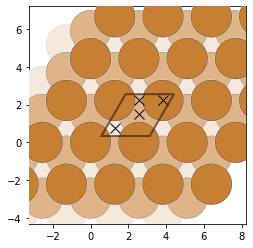

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot_slab(Cu_111, ax, adsorption_sites=True)
plt.show()

<br>We can now move on to adding adsorbates. Let's start by making a H molecule, that we can use as an adsorbate:

In [25]:
from pymatgen.core.structure import Molecule

adsorbate = Molecule("H", [[0, 0, 0]])

<br>We can now use the <i>generate_adsorption_structures()</i> method to create adsorption structures corresponding to the 4 adsorption sites we identified. Let's keep the same slab size by setting the <i>repeat</i> argument to [1, 1, 1]. We can control the distance between the adsorbate and the slab using the "distance" key in the dictionary passed to the <i>find_args</i> argument - let's make this 1.6 Å:

In [26]:
ads_structs = asf.generate_adsorption_structures(adsorbate, repeat=[1, 1, 1], find_args={"distance": 1.6})

<br>Let's visualize our new adsorption structures:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymatgen/core/structure.py:748: UserWarning: Not all sites have property bulk_wyckoff. Missing values are set to None.
  warnings.warn("Not all sites have property %s. Missing values " "are set to None." % k)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymatgen/core/structure.py:748: UserWarning: Not all sites have property bulk_equivalent. Missing values are set to None.
  warnings.warn("Not all sites have property %s. Missing values " "are set to None." % k)


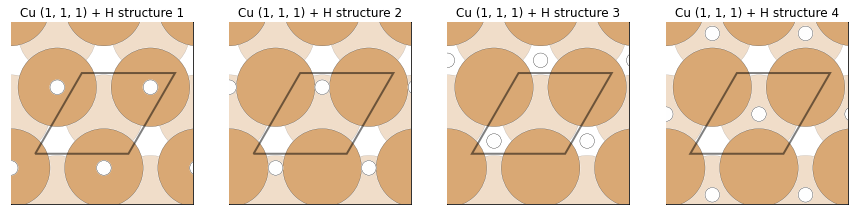

In [27]:
fig = plt.figure(figsize=[15, 60])
for n, ads_struct in enumerate(ads_structs):
    ax = fig.add_subplot(1, 4, n+1)
    plot_slab(ads_struct, ax, adsorption_sites=False)
    ax.set_title("Cu (1, 1, 1) + H structure %i" %(n+1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,5)
    ax.set_ylim(-1,4)
plt.show()